In [17]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import ImageFile
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
ImageFile.LOAD_TRUNCATED_IMAGES = True  




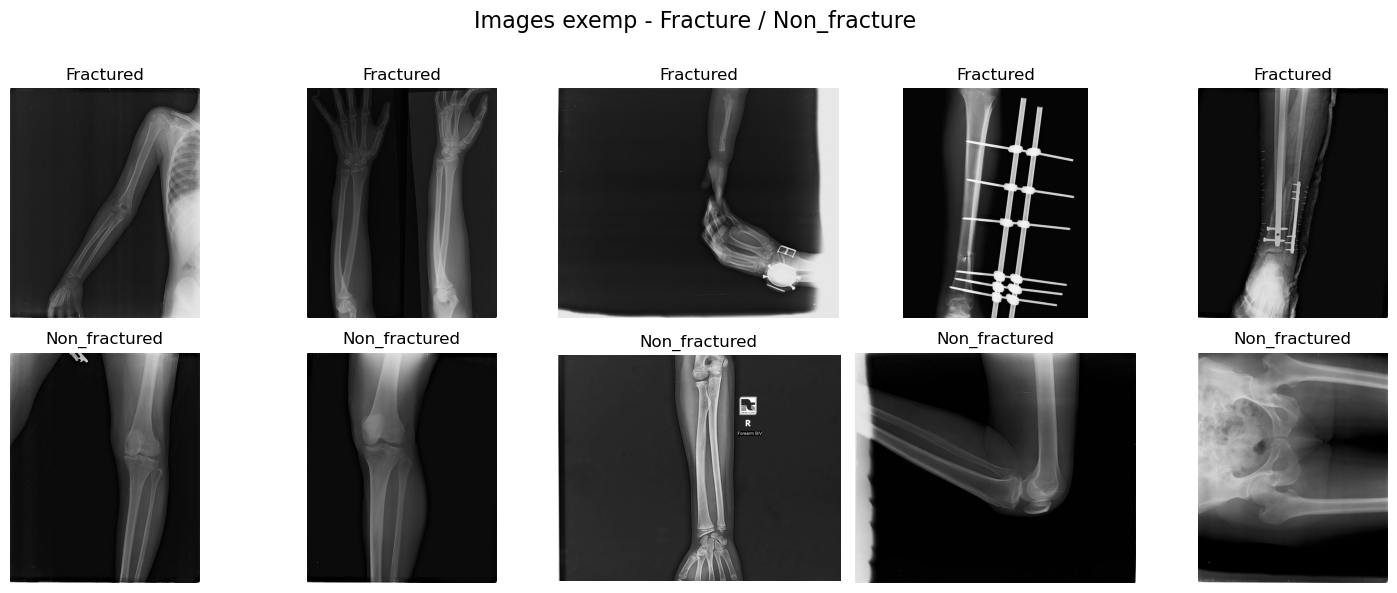

In [3]:


base_dir = "C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/images"
fractured_dir = os.path.join(base_dir, "1_Fractured")
nonfractured_dir = os.path.join(base_dir, "0_Non_fractured")

# Nomb d’images à afficher
num_images = 5

# Sélection aléatoire d'images
fractured_imgs = random.sample(
    [f for f in os.listdir(fractured_dir) if f.lower().endswith(('.jpg'))],
    num_images
)
nonfractured_imgs = random.sample(
    [f for f in os.listdir(nonfractured_dir) if f.lower().endswith(('.jpg'))],
    num_images
)

#  Affiche en 2 lignes
fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
fig.suptitle("Images exemp - Fracture / Non_fracture ", fontsize=16)

for i in range(num_images):
    axs[0, i].imshow(mpimg.imread(os.path.join(fractured_dir, fractured_imgs[i])), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Fractured")

    axs[1, i].imshow(mpimg.imread(os.path.join(nonfractured_dir, nonfractured_imgs[i])), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Non_fractured")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [40]:

# on va Génére les images avec normalisation
datagen = ImageDataGenerator(
     rescale=1./255,
   # rotation_range=20,
    # zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

#  Générator d'entraînement
train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

#  Générator de validation
val_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

#  Voir les classees attribuées automatiquement
print("Labels attribués par Keras :", train_generator.class_indices)


Found 1759 images belonging to 2 classes.
Found 752 images belonging to 2 classes.
Labels attribués par Keras : {'0_Non_fractured': 0, '1_Fractured': 1}


In [42]:


#  Charger MobileNetV2 
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Geler les poids de base

# Ajoutons la tête personnalisée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# modèle final
model = Model(inputs=base_model.input, outputs=predictions)


In [43]:

# compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # le Taux d’apprentissage classique
    loss=BinaryCrossentropy(from_logits=False),  #  Pour la classification binaire
    metrics=['accuracy']
)

#on Affichage des résultats le résumé du modèle
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
# on Entraîne le modèle sur 15 époques
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


c:\Users\josep\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.7654 - loss: 0.5794 - val_accuracy: 0.8218 - val_loss: 0.4506
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.8214 - loss: 0.4506 - val_accuracy: 0.8245 - val_loss: 0.4131
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.8451 - loss: 0.3875 - val_accuracy: 0.8298 - val_loss: 0.4020
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.8437 - loss: 0.3764 - val_accuracy: 0.8338 - val_loss: 0.3923
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.8627 - loss: 0.3547 - val_accuracy: 0.8231 - val_loss: 0.3873
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.8615 - loss: 0.3408 - val_accuracy: 0.8338 - val_loss: 0.3843
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.8749 - loss: 0.3211 - val_accuracy: 0.8431 - val_loss: 0.3742
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.8796 - loss: 0.3078 - val_accuracy: 0.8338 - v

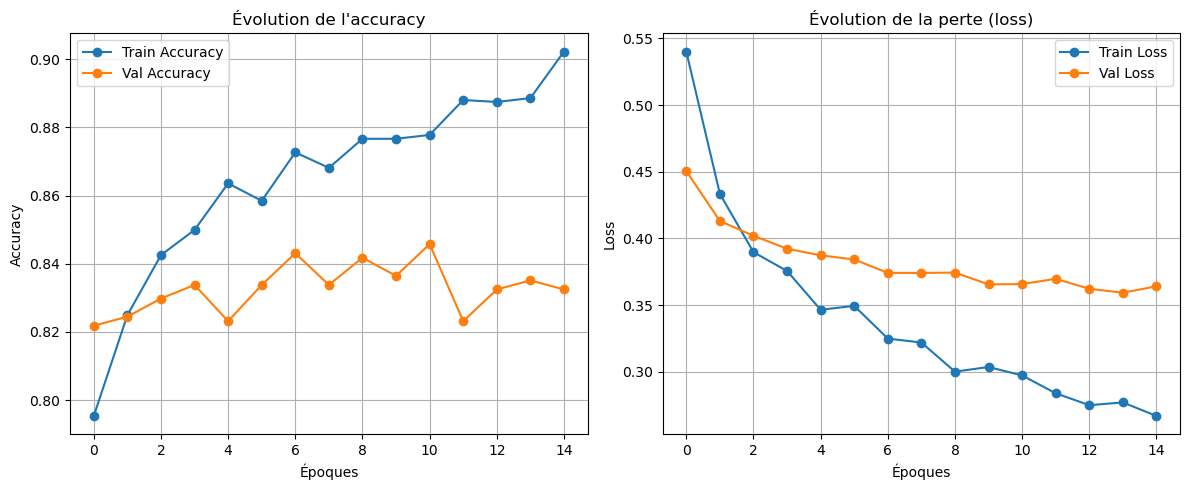

In [45]:

# afficharge de la Courbe d'précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Évolution de l'accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Évolution de la perte (loss)")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [46]:

model.save("fracture_mobilenetv2_model.h5")

print(" Modèle MobileNetV2 entraîné et sauvegardé avec succès.")


 Modèle MobileNetV2 entraîné et sauvegardé avec succès.


In [47]:

#on va faire une  Évaluation du modèle MobileNetV2 sur le jeu de test
# on Charger le modèle sauvegardé
model = load_model("fracture_mobilenetv2_model.h5")

# jeu test
test_dir ="C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/Test"

# Préparation des données
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Prédictions
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.15).astype("int32").reshape(-1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Résultats
acc = accuracy_score(true_labels, pred_classes)
print(f"Accuracy sur le jeu de test : {acc * 100:.2f}%\\n")

print(" Rapport de classification :")
print(classification_report(true_labels, pred_classes, target_names=class_names))

print(" Matrice de confusion :")
print(confusion_matrix(true_labels, pred_classes))




Found 1572 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step
Accuracy sur le jeu de test : 77.67%\n
 Rapport de classification :
                 precision    recall  f1-score   support

0_Non_fractured       0.93      0.79      0.85      1297
    1_Fractured       0.42      0.73      0.54       275

       accuracy                           0.78      1572
      macro avg       0.68      0.76      0.69      1572
   weighted avg       0.84      0.78      0.80      1572

 Matrice de confusion :
[[1019  278]
 [  73  202]]


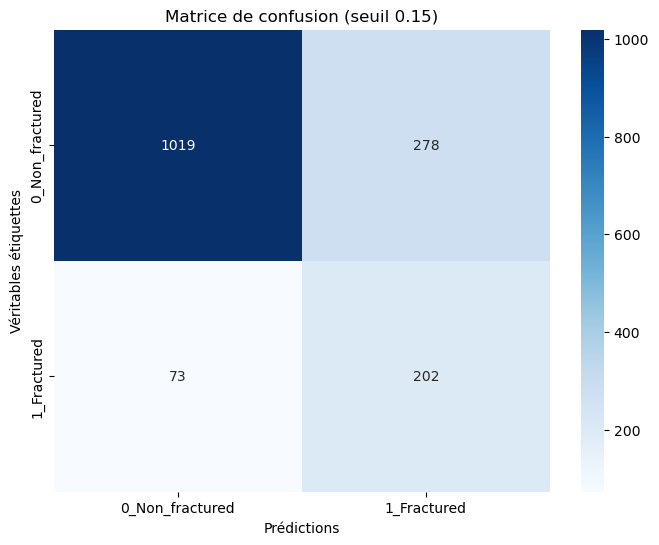

In [49]:


# Vrais labels et prédict
true_labels = test_generator.classes
pred_classes = (pred_probs > 0.15).astype("int32").reshape(-1)

# Matric de confusi
cm = confusion_matrix(true_labels, pred_classes)
class_names = list(test_generator.class_indices.keys())


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.title('Matrice de confusion (seuil 0.15)')
plt.show()


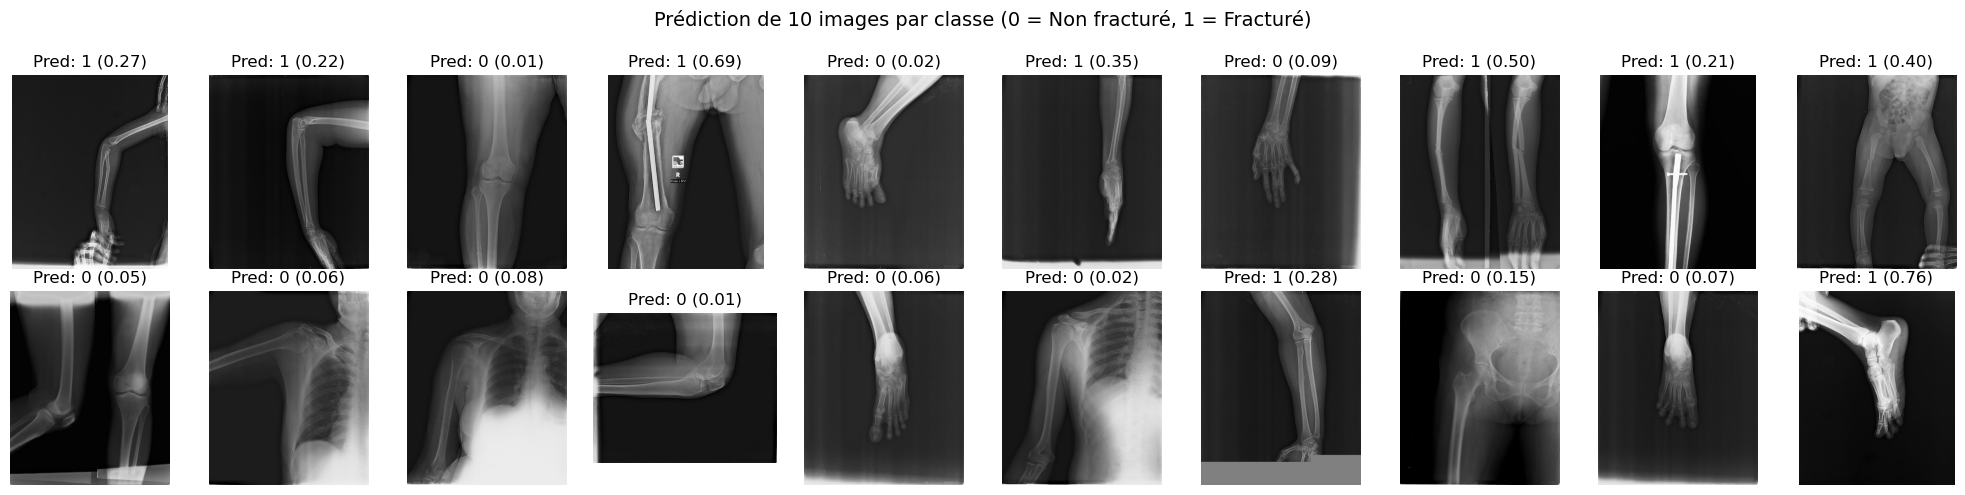

In [52]:

# === PARAMÈTRES ===
model_path = "fracture_mobilenetv2_model.h5"  # ou ton modèle final
image_size = (224, 224)
base_test_dir = "C:/Users/josep/OneDrive/Documenten/project419/FracAtlas/Test"

# === CHARGER LE MODÈLE ===
model = load_model(model_path)

# === FONCTION UTILITAIRE POUR PREDIRE ===
def predict_image(path):
    img = load_img(path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)[0][0]
    return pred

# === EXTRAIRE LES IMAGES ===
fractured_dir = os.path.join(base_test_dir, "1_Fractured")
nonfractured_dir = os.path.join(base_test_dir, "0_Non_fractured")

fractured_imgs = random.sample(os.listdir(fractured_dir), 10)
nonfractured_imgs = random.sample(os.listdir(nonfractured_dir), 10)

# === AFFICHER LES PRÉDICTIONS ===
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle("Prédiction de 10 images par classe (0 = Non fracturé, 1 = Fracturé)", fontsize=14)

for i, img_name in enumerate(fractured_imgs):
    path = os.path.join(fractured_dir, img_name)
    pred = predict_image(path)
    label = "1_Fractured"
    axs[0, i].imshow(load_img(path), cmap='gray')
    axs[0, i].set_title(f"Pred: {int(pred>0.15)} ({pred:.2f})")
    axs[0, i].axis('off')

for i, img_name in enumerate(nonfractured_imgs):
    path = os.path.join(nonfractured_dir, img_name)
    pred = predict_image(path)
    label = "0_Non_fractured"
    axs[1, i].imshow(load_img(path), cmap='gray')
    axs[1, i].set_title(f"Pred: {int(pred>0.15)} ({pred:.2f})")
    axs[1, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
